In [3]:
using Clustering
using MultivariateStats
using StatsBase
using CSV
using DataFrames
using CairoMakie
using GaussianMixtures
using MLBase
using Hungarian
using LinearAlgebra

In [4]:
# Stop showing warnings
using Suppressor: @suppress_err

In [5]:
function ground_true(df_1, df_2)
    a = fill(1,nrow(df_1))
    b = fill(2,nrow(df_2))
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [6]:
# n is the number of cluters
# remember standardize trees for better performance
function kmeans_label(tree, n; seed =:kmpp)  
    # apply kmeans clustering
    # init works like seed of random, Its length should be the same as the number of clusters    
    result = kmeans(tree, n, init = seed);
    return result.assignments
end;


function GMM_label(tree, n; method=:kmeans, kind=:diag)    
    data= tree';
    gmm=GMM(n,Array(data),method=method, kind=kind);
    prob_pos=gmmposterior(gmm,Array(data))[1]
    llpg = gmmposterior(gmm,Array(data))[2]
    llpg_result = map(argmax, eachrow(llpg))
    prob_result = map(argmax, eachrow(prob_pos))
    return Pair(llpg_result, prob_result)
end;

function dbscan_label(tree, radius; min_neighbors = 1, min_cluster_size = 1)   
    result = dbscan(tree, radius,min_neighbors = min_neighbors, min_cluster_size = min_cluster_size)   
    # get only points in clusters
    result = getproperty.(result, :core_indices)
    idx = fill(0,length(tree[1,:]))
    for i in range(1, length(idx))
        if i in result[1]
            idx[i] = 1
        elseif i in result[2]
            idx[i] = 2
        end
    end
    return idx
end;
# Performance Check

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

accuracy (generic function with 1 method)

In [7]:
# Kmeans
function kmeans_matrix(trees, path)
    n = length(trees)
    result = zeros(n, n)
    for i in 1:n
        if i == 1
            continue
        end
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            pred_kmeans = kmeans_label(tree, 2)
            m,x = accuracy(2, gt, pred_kmeans)
            result[i,j] = x
            result[j,i] = x
        end
    end      
    header = Vector(1:n)
    header = string.(header)
    CSV.write(path, DataFrame(result, :auto),header = header);
end

kmeans_matrix (generic function with 1 method)

In [8]:
# GMM
function gmm_matrix(trees, path_prob, path_llpg)
    @suppress_err begin
        n = length(trees)
        result_prob = zeros(n, n)
        result_llpg = zeros(n, n)
        for i in 1:n
            if i == 1
                continue
            end
            for j in  1:(i - 1)
                gt = ground_true(trees[i],trees[j])
                tree = vcat(trees[i],trees[j])
                tree = standardize_tree(tree)
                pred_prob, pred_llpg = GMM_label(tree, 2, method = :split)
                m,x = accuracy(2, gt, pred_prob)
                result_prob[i,j] = x
                result_prob[j,i] = x

                m,x = accuracy(2, gt, pred_llpg)
                result_llpg[i,j] = x
                result_llpg[j,i] = x        
            end
        end 
    
        header = Vector(1:n)
        header = string.(header)
        CSV.write(path_prob, DataFrame(result_prob, :auto),header = header);
        CSV.write(path_llpg, DataFrame(result_llpg, :auto),header = header);
    end
end

gmm_matrix (generic function with 1 method)

In [1]:
mutable struct UnrootedTree
    nodeNumber::Int64
    nodeLengths::Vector{Float64}
    innerBranch::String
    innerLenght::Float64
end

function Base.show(io::IO, t::UnrootedTree)
    println(io, "Unrooted Tree\n$(t.nodeNumber) nodes\n1|234: $(t.nodeLengths[1])\n2|134: $(t.nodeLengths[2])\n3|124: $(t.nodeLengths[3])\n4|123: $(t.nodeLengths[4])\n$(t.innerBranch): $(t.innerLenght)")
end

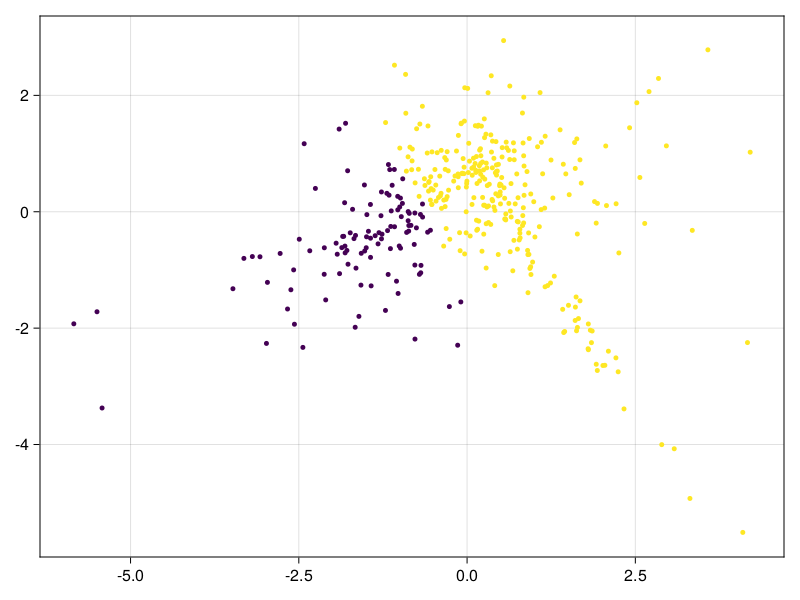

In [15]:
org_network = CSV.read("./data/network.csv", DataFrame)
network = standardize_tree(org_network)
label_NK = kmeans_label(network, 2)
plot_clusters(network, label_NK)

K-means converged with 9 iterations (objv = 2351.71191575412)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 7 dimensions using 400 data points
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:79
┌ Info: K-means with 400 data points using 9 iterations
│ 25.0 data points per parameter
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:141
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1

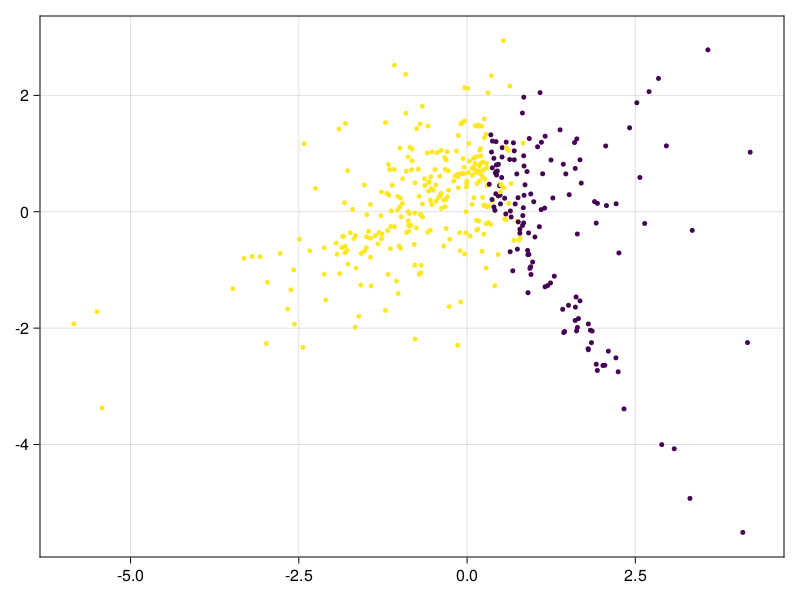

In [31]:
label_NG = GMM_label(network, 2)[2]
plot_clusters(network, label_NG)

In [11]:
tree_1 = CSV.read("./data/network_tree_1.csv", DataFrame)
tree_2 = CSV.read("./data/network_tree_2.csv", DataFrame)
gt = ground_true(tree_1, tree_2)
org_tree = vcat(tree_1,tree_2)
tree = standardize_tree(org_tree);

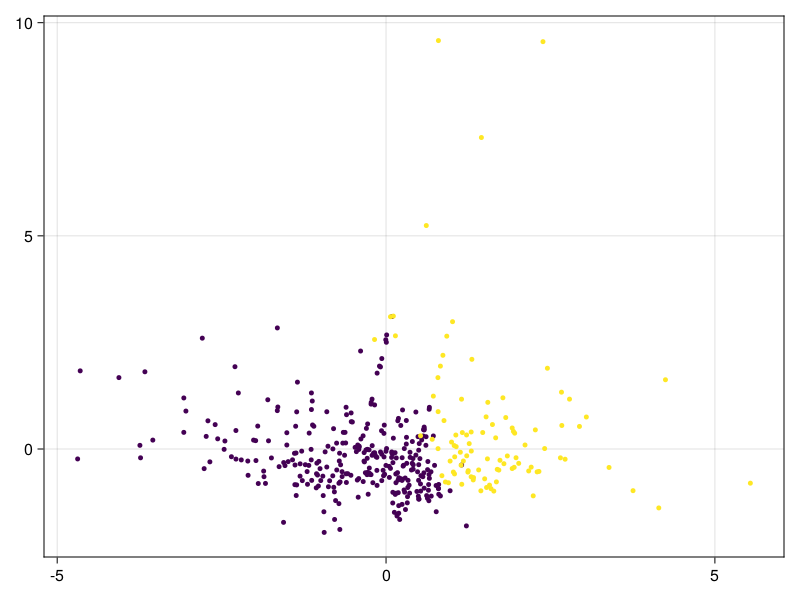

0.62

In [35]:
label_K = kmeans_label(tree, 2)
matrix, x = accuracy(2, gt, label_K)
display(plot_clusters(tree, label_K))
print(x)

K-means converged with 10 iterations (objv = 2353.7293028137424)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 7 dimensions using 400 data points
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:79
┌ Info: K-means with 400 data points using 10 iterations
│ 25.0 data points per parameter
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:141
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind 

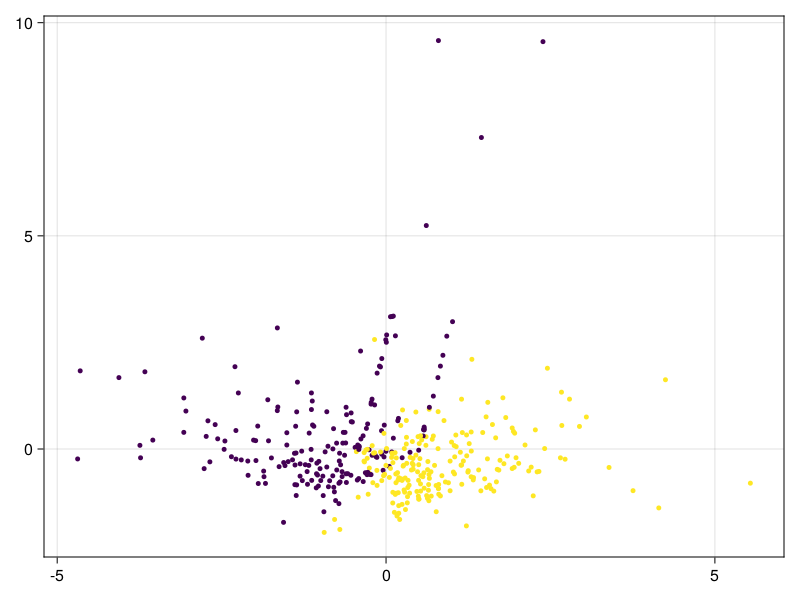

0.7725

In [42]:
label_GMM = GMM_label(tree, 2)[2]
display(plot_clusters(tree, label_GMM))
matrix, x = accuracy(2, gt, label_GMM)
 print(x)

In [43]:
org_tree = Matrix(org_tree)
tree_K_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_K_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_K[i] == 1
        tree_K_1 += org_tree[i,:]
        n_1 += 1
    else
        tree_K_2 += org_tree[i,:]
        n_2 += 1
    end
end
tree_K_1 /= n_1
tree_K_2 /= n_2;

In [44]:
tree_G_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_G_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_GMM[i] == 1
        tree_G_1 += org_tree[i,:]
        n_1 += 1
    else
        tree_G_2 += org_tree[i,:]
        n_2 += 1
    end
end
tree_G_1 /= n_1
tree_G_2 /= n_2;

In [45]:
org_network = Matrix(org_network)
tree_NK_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_NK_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_NK[i] == 1
        tree_NK_1 += org_network[i,:]
        n_1 += 1
    else
        tree_NK_2 += org_network[i,:]
        n_2 += 1
    end
end
tree_NK_1 /= n_1
tree_NK_2 /= n_2;

In [46]:
tree_NG_1 = [0,0,0,0,0,0,0]
n_1 = 0
tree_NG_2 = [0,0,0,0,0,0,0]
n_2 = 0
for i in 1:400
    if label_NG[i] == 1
        tree_NG_1 += org_network[i,:]
        n_1 += 1
    else
        tree_NG_2 += org_network[i,:]
        n_2 += 1
    end
end
tree_NG_1 /= n_1
tree_NG_2 /= n_2;

In [47]:
println("Network, Kmeans:")
println(tree_NK_1)
println(tree_NK_2)
println("Network, GMM:")
println(tree_NG_1)
println(tree_NG_2)
println("Tree, Kmeans:")
println(tree_K_1)
println(tree_K_2)
println("Tree, GMM:")
println(tree_G_1)
println(tree_G_2)

Network, Kmeans:
[1.7308109566726257, 1.483104534654277, 2.192769836156679, 1.9668528086460193, 2.1094695704266537, 0.0, 0.0]
[2.5076419280951128, 1.9212711133669051, 0.9045389645694474, 3.0585222646322836, 0.22512800579132028, 0.280071036114473, 0.3540992174347099]
Network, GMM:
[3.0074555889829497, 2.2912665961559413, 0.853742658721087, 2.363580648281069, 0.002818286946585962, 0.585631916243564, 0.7245091840945083]
[1.9253261584119041, 1.5469382684171904, 1.4649049680075976, 2.9680851191479274, 1.1218947815593052, 0.004825471421837918, 0.014392068640885644]
Tree, Kmeans:
[1.5606375851333216, 1.7439995206515753, 1.9342252358154983, 3.4697358266634786, 0.7418452646154975, 0.04656763662128244, 0.27913135755603785]
[3.070125534895524, 2.1554484610649705, 1.6372757444713846, 1.5698051355308733, 0.009464465720093115, 0.280900223264524, 1.844825623241794]
Tree, GMM:
[1.551766392327704, 1.957931550197179, 2.224581207439216, 2.674894343380377, 1.1467307316406452, 0.21026864423139296, 0.000191

In [48]:
using Combinatorics

# n is the number of nodes

function bipartToTree(tree, n)
    # delete the two shortest lengths
    # the index of length should not be less than the number of nodes 
    count = 0
    for length in tree
        if length == 0
            count = count + 1
        end
    end
    
    if count != 2
        idx1 = findmin(tree)[2]
        idx2 = 1
        for i in n:length(tree)
            if i == idx1
                continue
            else
                if tree[i] <= tree[idx2]
                    idx2 = i
                end
            end
        end
        tree[idx1] = 0
        tree[idx2] = 0
    end
    
    lengths = tree[(n+1):length(tree)]
    idx1 = findmax(lengths)[2]
    
    comb = combinations(Vector(1:n),2)   # only for n=4
    idx2 = 0
    for c in comb
        idx2 = idx2 + 1
        if idx2 == idx1
            comb = c
        end
    end
    node = Vector(1:n)
    right = setdiff(node ,comb)
    
    innerBranch = ""
    
    for i in comb
        innerBranch = innerBranch * string(i)
    end  
    innerBranch = innerBranch * "|"  
    for i in right
        innerBranch = innerBranch * string(i)
    end
    
    unRootedTree = UnrootedTree(n, tree[1:n], innerBranch, findmax(lengths)[1])
end

bipartToTree (generic function with 1 method)

In [49]:
tree_NK_1 = bipartToTree(tree_NK_1, 4)
tree_NK_2 = bipartToTree(tree_NK_2, 4)
tree_NG_1 = bipartToTree(tree_NG_1, 4)
tree_NG_2 = bipartToTree(tree_NG_2, 4)
tree_K_1 = bipartToTree(tree_K_1, 4)
tree_K_2 = bipartToTree(tree_K_2, 4)
tree_G_1 = bipartToTree(tree_G_1, 4)
tree_G_2 = bipartToTree(tree_G_2, 4)

Unrooted Tree
4 nodes
1|234: 2.262098068401476
2|134: 1.73748316006055
3|124: 1.532478146106573
4|123: 3.3234266255072242
14|23: 1.2532184093707723


In [50]:
println("Network, Kmeans:")
println(tree_NK_1)
println(tree_NK_2)
println("Network, GMM:")
println(tree_NG_1)
println(tree_NG_2)
println("Tree, Kmeans:")
println(tree_K_1)
println(tree_K_2)
println("Tree, GMM:")
println(tree_G_1)
println(tree_G_2)

Network, Kmeans:
Unrooted Tree
4 nodes
1|234: 1.7308109566726257
2|134: 1.483104534654277
3|124: 2.192769836156679
4|123: 1.9668528086460193
12|34: 2.1094695704266537

Unrooted Tree
4 nodes
1|234: 2.5076419280951128
2|134: 1.9212711133669051
3|124: 0.9045389645694474
4|123: 3.0585222646322836
14|23: 0.3540992174347099

Network, GMM:
Unrooted Tree
4 nodes
1|234: 3.0074555889829497
2|134: 2.2912665961559413
3|124: 0.853742658721087
4|123: 2.363580648281069
14|23: 0.7245091840945083

Unrooted Tree
4 nodes
1|234: 1.9253261584119041
2|134: 1.5469382684171904
3|124: 1.4649049680075976
4|123: 2.9680851191479274
12|34: 1.1218947815593052

Tree, Kmeans:
Unrooted Tree
4 nodes
1|234: 1.5606375851333216
2|134: 1.7439995206515753
3|124: 1.9342252358154983
4|123: 3.4697358266634786
12|34: 0.7418452646154975

Unrooted Tree
4 nodes
1|234: 3.070125534895524
2|134: 2.1554484610649705
3|124: 1.6372757444713846
4|123: 1.5698051355308733
14|23: 1.844825623241794

Tree, GMM:
Unrooted Tree
4 nodes
1|234: 1.5